In [1]:
import sys

sys.path.append('../modules/')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

from correlation_degitization import CorrelationDigitization
from conformity_digitization import ConformityDigitization
from centrifugal_digitization import CentrifugalDigitization
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import datetime
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',33)


In [2]:
def fillna(hotel_data, replase_dict):
    for column, value in replase_dict.items():
        hotel_data[column] = hotel_data[column].fillna(value)
        


In [3]:
HOTEL_PATH = '../../datasets/'
FILE_NAME = 'hotel_bookings.csv'
def load_hotel_data(hotel_path =  HOTEL_PATH, file_name = FILE_NAME):
    csv_path = os.path.join(hotel_path, file_name)
    return pd.read_csv(csv_path)

# Начальные сведения

In [4]:
hotel_data = load_hotel_data()
hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [5]:
print(f'Размер {hotel_data.shape}')
print(f'Все колонки: {" ".join(hotel_data.columns.values)}')

Размер (119390, 32)
Все колонки: hotel is_canceled lead_time arrival_date_year arrival_date_month arrival_date_week_number arrival_date_day_of_month stays_in_weekend_nights stays_in_week_nights adults children babies meal country market_segment distribution_channel is_repeated_guest previous_cancellations previous_bookings_not_canceled reserved_room_type assigned_room_type booking_changes deposit_type agent company days_in_waiting_list customer_type adr required_car_parking_spaces total_of_special_requests reservation_status reservation_status_date


In [6]:
hotel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [7]:
categorial_columns = ['hotel','meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','agent','customer_type','company']
number_columns = ['booking_changes','lead_time','stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled','days_in_waiting_list','adr','required_car_parking_spaces', 'total_of_special_requests']
predict_column = 'is_canceled'
arrival_columns = ['arrival_date_year', 'arrival_date_month','arrival_date_week_number', 'arrival_date_day_of_month']
binary_columns = ['is_repeated_guest']
deleted_columns = ['reservation_status', 'reservation_status_date']

hotel_data = hotel_data.drop(deleted_columns,axis = 1 )
print(f'Классифицируемый признак:  {predict_column}')
print(f'Категориальные признаки: {" ".join(categorial_columns)}')
print(f'Количественные признаки: {" ".join(number_columns)}')
print(f'Признаки характерезующие прибытие клиента: {" ".join(arrival_columns)}')
print(f'Бинарные признаки: {" ".join(binary_columns)}')

Классифицируемый признак:  is_canceled
Категориальные признаки: hotel meal country market_segment distribution_channel reserved_room_type assigned_room_type deposit_type agent customer_type company
Количественные признаки: booking_changes lead_time stays_in_weekend_nights stays_in_week_nights adults children babies previous_cancellations previous_bookings_not_canceled days_in_waiting_list adr required_car_parking_spaces total_of_special_requests
Признаки характерезующие прибытие клиента: arrival_date_year arrival_date_month arrival_date_week_number arrival_date_day_of_month
Бинарные признаки: is_repeated_guest


/home/hvidsmen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


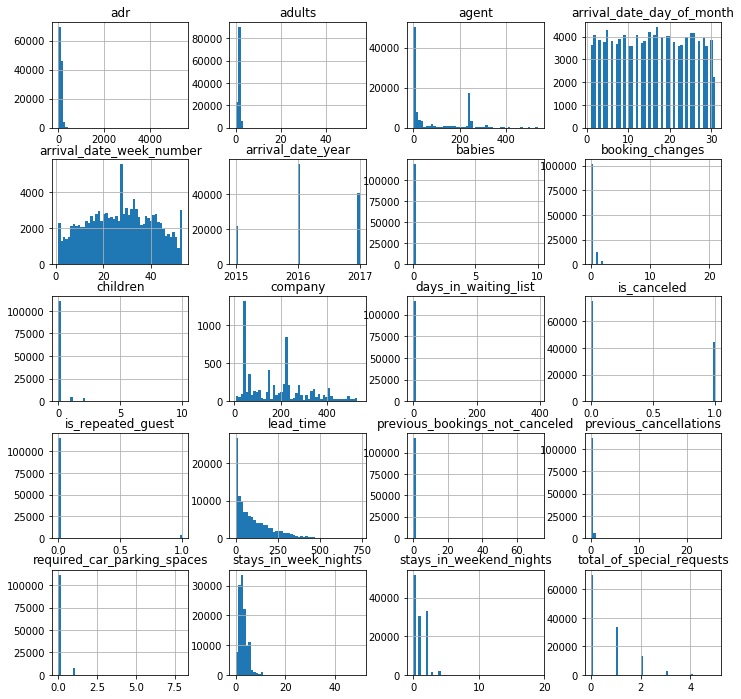

In [8]:
fig, ax = plt.subplots(ncols=1, nrows = 1, figsize= (12,12))
hotel_data.hist(bins = 50,figsize=(20,15),ax=ax)
fig.savefig('./Hotel_fig/hist.png')
plt.show()

# Заполнение пропусков 

In [9]:
print('В каких столюцах есть пропуски')
columns_null = []
values_replase = [0,'PTR',0,0]
for column in hotel_data.columns:
    condition = hotel_data[column].isnull().values.any()
    if condition:
        columns_null+=[column]
        print(f'{column}')
replase_dict = dict(zip(columns_null,values_replase))
print(f'Замена nan {replase_dict}')
fillna(hotel_data,replase_dict)

В каких столюцах есть пропуски
children
country
agent
company
Замена nan {'children': 0, 'country': 'PTR', 'agent': 0, 'company': 0}


# Работа с датой

In [10]:
month_coder = {'December':12,'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,"August":8,'September':9,'October':10,'November':11}
hotel_data["arrival_date_month"] = hotel_data['arrival_date_month'].map(month_coder)
hotel_data["arrival_date_month"] = hotel_data["arrival_date_month"].astype('int')
def get_number_day_arrival(row):
    day = (datetime.datetime(4,row['arrival_date_month'], row['arrival_date_day_of_month']) - datetime.datetime(4,1,1) ).days
    return day
def is_tired_weekend_day(value):
    w =1  if value%7==0 or value%6 == 0 else 0
    return w 

hotel_data['number_day_arrival']= hotel_data.apply(get_number_day_arrival,axis= 1)
hotel_data['is_day_of_rest_arrival'] = hotel_data['number_day_arrival'].apply(is_tired_weekend_day)
hotel_data = hotel_data.drop(labels=arrival_columns,axis=1)
arrival_columns = ['number_day_arrival','is_day_of_rest_arrival']

# Маштабирование


In [11]:
scalered = StandardScaler()
scalered.fit(hotel_data[number_columns])
hotel_data[number_columns] = scalered.transform(hotel_data[number_columns])

/home/hvidsmen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Присвоение категориальным признакам меток


In [12]:
conformity_categorials = ['agent', 'deposit_type', 'hotel']
centrifugal_categorials = ['customer_type','country', 'distribution_channel','assigned_room_type','reserved_room_type','market_segment','meal','company']
con_dig = ConformityDigitization()
con_dig.fit(hotel_data[conformity_categorials])
hotel_data= con_dig.transform(hotel_data)
for column in centrifugal_categorials:
    centr_dig = CentrifugalDigitization()
    centr_dig.fit(hotel_data,predict_column,column)
    hotel_data = centr_dig.transform(hotel_data)



# Удаление выбросов

In [13]:
X = hotel_data.drop(labels=predict_column, axis=1)
db = DBSCAN(eps = 2,min_samples = 3)
X = hotel_data.drop(labels=[predict_column] ,axis=1)
db.fit(X)
hotel_data = hotel_data.drop(np.where(db.labels_==-1)[0])

# Результирующая ковариация

In [14]:
corr_matrix = hotel_data.corr()
corr_matrix['is_canceled'].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.296803
assigned_room_type                0.119959
previous_cancellations            0.117974
customer_type                     0.069761
adults                            0.066615
adr                               0.056798
days_in_waiting_list              0.053336
children                          0.025291
stays_in_week_nights              0.023211
is_day_of_rest_arrival            0.012527
number_day_arrival                0.011497
meal                              0.008454
agent                             0.004381
company                          -0.001843
stays_in_weekend_nights          -0.005552
reserved_room_type               -0.006843
babies                           -0.015370
hotel                            -0.029727
market_segment                   -0.035607
deposit_type                     -0.047622
previous_bookings_not_canceled   -0.062726
is_repeated_guest                -0.065597
distributio

# Результируещее описание

In [15]:
hotel_data.describe(include='all')

,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,number_day_arrival,is_day_of_rest_arrival
count,1.109330e+05,110933.000000,110933.000000,110933.000000,110933.000000,110933.000000,110933.000000,110933.000000,1.109330e+05,1.109330e+05,1.109330e+05,1.109330e+05,110933.000000,110933.000000,110933.000000,1.109330e+05,1.109330e+05,110933.000000,1.109330e+05,1.109330e+05,1.109330e+05,110933.000000,1.109330e+05,110933.000000,110933.000000,110933.000000,110933.000000,110933.000000
mean,-1.670919e-03,0.383222,0.009284,-0.036986,-0.043847,-0.001127,-0.082000,-0.066407,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.023465,-0.005373,-0.063008,1.000000e+00,1.000000e+00,-0.098615,-1.670919e-03,-1.670919e-03,-1.000000e+00,0.003474,-1.000000e+00,-0.028760,-0.067668,-0.051201,183.468941,0.298874
std,3.291958e-15,0.486174,1.004784,0.932749,0.886715,0.805981,0.827653,0.394324,1.616080e-16,1.821336e-15,6.048713e-16,2.799252e-16,0.151374,1.005795,0.283126,6.574027e-16,3.335121e-16,0.727078,2.819235e-15,2.883924e-15,2.565662e-15,1.015249,3.833946e-16,0.893193,0.853323,0.944191,94.310121,0.457767
min,-1.670919e-03,0.000000,-0.973319,-0.928890,-1.310240,-3.204792,-0.260659,-0.081579,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,-0.103180,-0.091555,1.000000e+00,1.000000e+00,-0.338990,-1.670919e-03,-1.670919e-03,-1.000000e+00,-0.131924,-1.000000e+00,-2.015038,-0.254873,-0.720694,0.000000,0.000000
25%,-1.670919e-03,0.000000,-0.795520,-0.928890,-0.786207,0.247897,-0.260659,-0.081579,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,-0.103180,-0.091555,1.000000e+00,1.000000e+00,-0.338990,-1.670919e-03,-1.670919e-03,-1.000000e+00,-0.131924,-1.000000e+00,-0.635812,-0.254873,-0.720694,108.000000,0.000000
50%,-1.670919e-03,0.000000,-0.318272,0.072502,-0.262174,0.247897,-0.260659,-0.081579,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,-0.103180,-0.091555,1.000000e+00,1.000000e+00,-0.338990,-1.670919e-03,-1.670919e-03,-1.000000e+00,-0.131924,-1.000000e+00,-0.154963,-0.254873,-0.720694,186.000000,0.000000
75%,-1.670919e-03,1.000000,0.533288,1.073895,0.261858,0.247897,-0.260659,-0.081579,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,-0.103180,-0.091555,1.000000e+00,1.000000e+00,-0.338990,-1.670919e-03,-1.670919e-03,-1.000000e+00,-0.131924,-1.000000e+00,0.436700,-0.254873,0.540666,260.000000,1.000000
max,-1.670919e-03,1.000000,4.912742,7.082251,10.218481,3.700587,7.266561,10.181591,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000,30.690364,16.603710,1.000000e+00,1.000000e+00,24.189494,-1.670919e-03,-1.670919e-03,-1.000000e+00,22.090744,-1.000000e+00,5.662721,3.821932,5.586106,365.000000,1.000000


# Визуализация



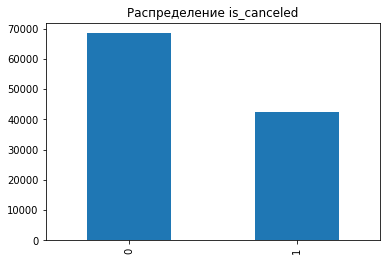

In [16]:
fig, ax = plt.subplots(1,1)
ax.set_title(f'Распределение {predict_column}')
hotel_data.is_canceled.value_counts().plot.bar(ax = ax)
fig.savefig('./Hotel_fig/kde.png')
plt.show()

### Зависимость количества  не количественных признаков

/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

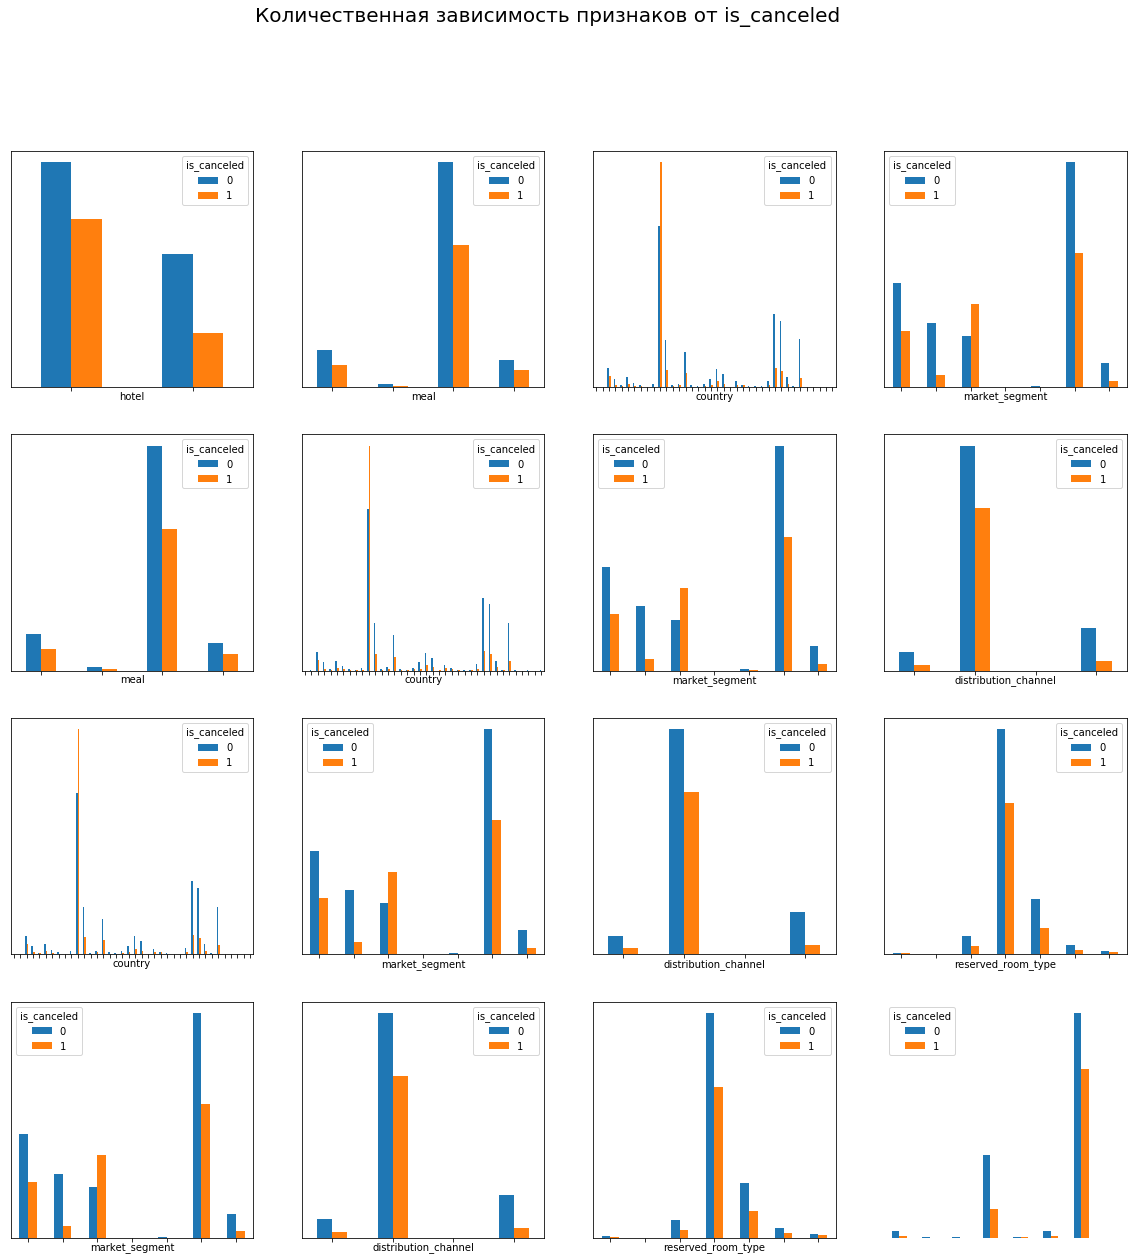

In [17]:
plot_arr = categorial_columns + binary_columns

nrows = 4
ncolst = 4
fig, axs = plt.subplots(ncols= ncolst, nrows = nrows, figsize= (20,20))
fig.suptitle(f'Количественная зависимость признаков от {predict_column} ', size = 20)
plt.axis('off') 
for i in range(nrows):
    for j in range(nrows):
        if i+j >= len(plot_arr):
            continue
        column = plot_arr[i+j]
        ct = pd.crosstab(hotel_data[column], hotel_data[predict_column])
        
        axs[i][j].set_yticks([])
        axs[i][j].tick_params(labelbottom='off')   
        axs[i][j].set_xticks([])
        ct.plot.bar(ax = axs[i][j])
fig.savefig('./Hotel_fig/depend_cat.png')
plt.show()

### Зависисомть всех признаков

/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbo

/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/home/hvidsmen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


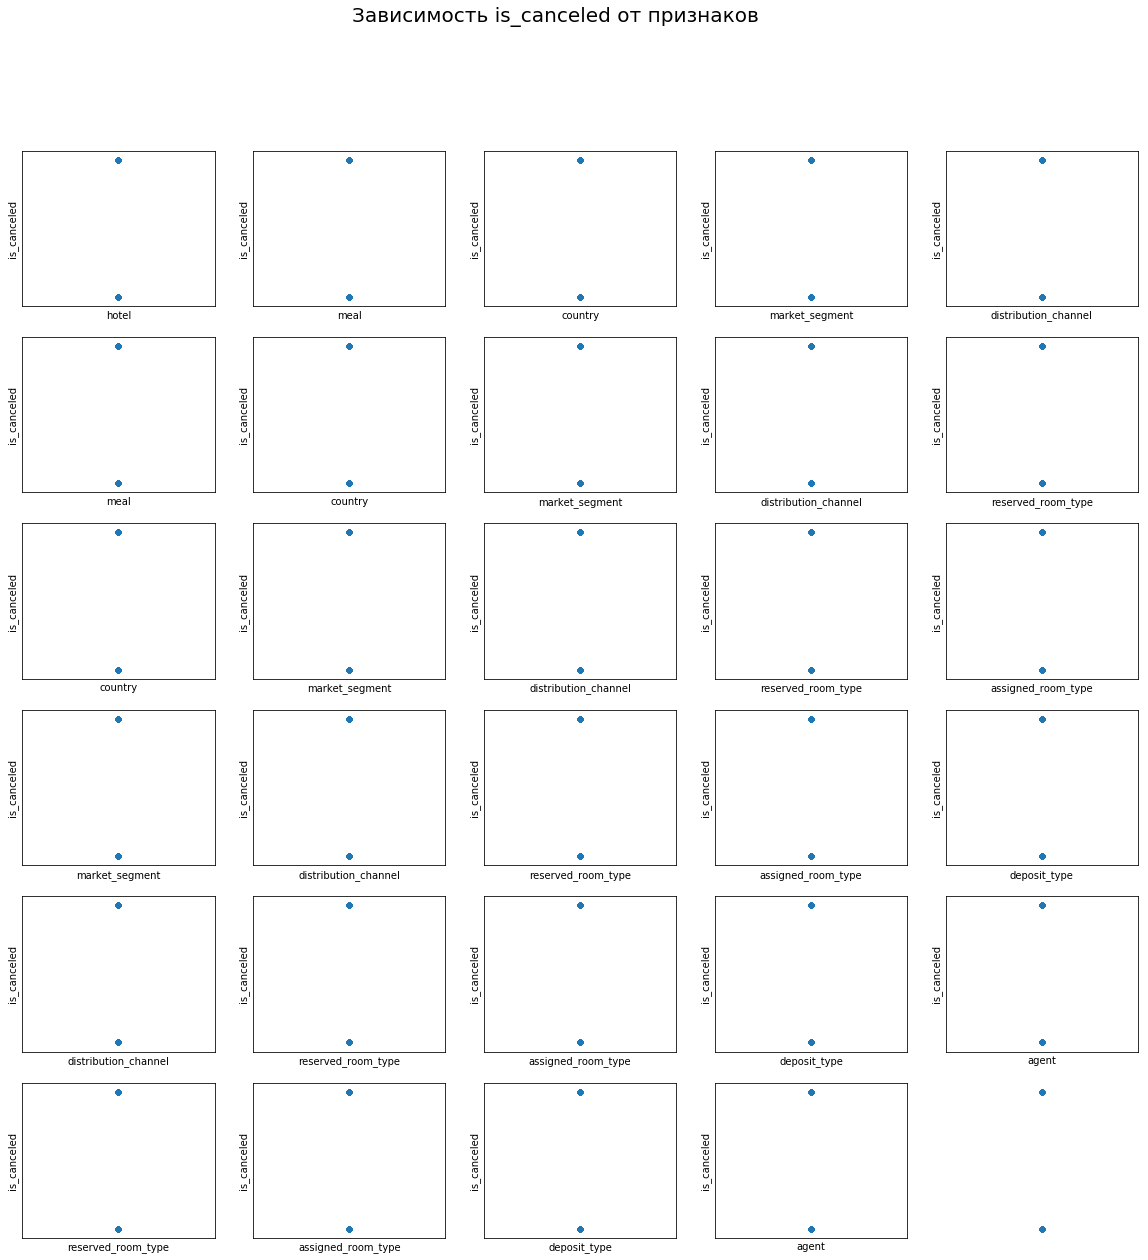

In [18]:
plot_arr = categorial_columns + binary_columns +arrival_columns + number_columns
nrows = 6
ncols = 5

fig, axs = plt.subplots(ncols= ncols, nrows = nrows, figsize= (20,20))
fig.suptitle(f'Зависимость {predict_column} от признаков  ', size = 20)
plt.axis('off') 
for i in range(nrows):
    for j in range(ncols):
        if i+j >= len(plot_arr):
            continue
        column = plot_arr[i+j]        
        axs[i][j].set_yticks([])
        axs[i][j].tick_params(labelbottom='off')   
        axs[i][j].set_xticks([])
        hotel_data.plot.scatter(x=column, y=predict_column, ax = axs[i][j])
fig.savefig('./Hotel_fig/depend.png')
plt.show()

In [19]:
from sklearn.manifold import TSNE
hotel_data_tsne = TSNE().fit_transform(hotel_data.drop(labels = predict_column,axis = 1))

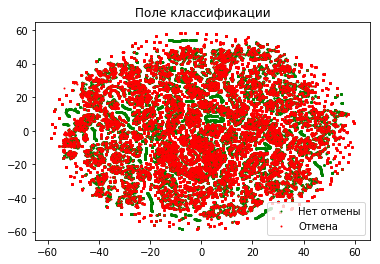

In [20]:
plt.scatter(hotel_data_tsne[hotel_data[predict_column]==0, 0], hotel_data_tsne[hotel_data[predict_column]==0, 1], c='green', label='Нет отмены',s=1)
plt.scatter(hotel_data_tsne[hotel_data[predict_column]==1, 0], hotel_data_tsne[hotel_data[predict_column]==1, 1], c = 'red', label = 'Отмена',s = 1)
plt.title('Поле классификации')
plt.legend()
fig.savefig('./Hotel_fig/tsne.png')
plt.show()